In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from googletrans import Translator
import emoji
import re

# Exploratory Data Analysis

In [2]:
data = pd.read_csv('./data/twitter_MBTI.csv').drop(columns='Unnamed: 0')
data.head()

,text,label
0,@Pericles216 @HierBeforeTheAC @Sachinettiyil T...,intj
1,@Hispanthicckk Being you makes you look cute||...,intj
2,@Alshymi Les balles sont réelles et sont tirée...,intj
3,"I'm like entp but idiotic|||Hey boy, do you wa...",intj
4,@kaeshurr1 Give it to @ZargarShanif ... He has...,intj


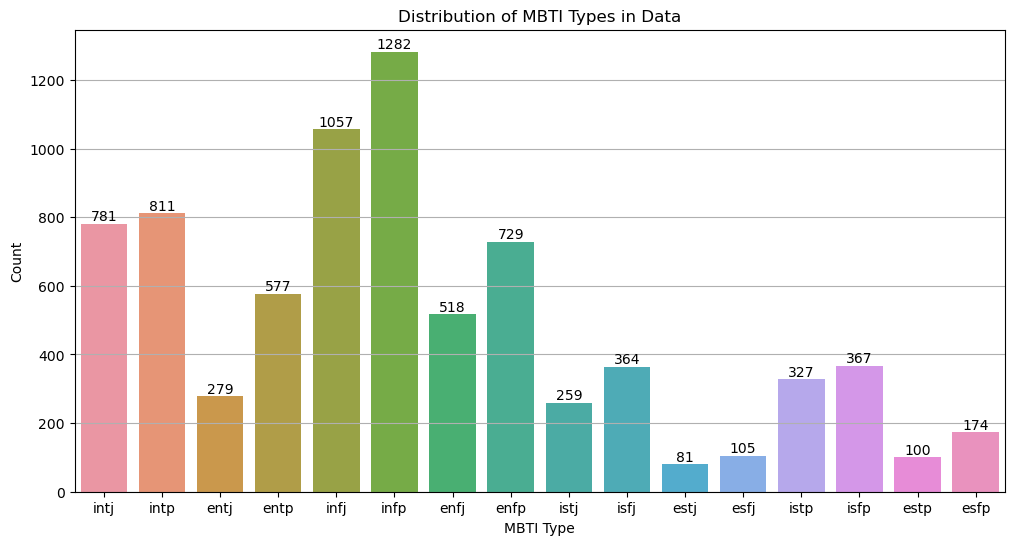

In [3]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(x='label', data=data)
plt.xlabel('MBTI Type')
plt.ylabel('Count')

for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2.0, 
        height,
        f'{int(height)}',
        ha='center', 
        va='bottom'
    )
    
plt.title('Distribution of MBTI Types in Data')
ax.yaxis.grid()
plt.show()

We can see there is an uneven distribution in the classes in our data. This may cause issues with our model classifying these uncommon classes.

C:\Users\ritac\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: title={'center': 'Distribution of Number of Words in All Tweets in our Data Per User'}, xlabel='Number of Words in All Tweets', ylabel='Count'>

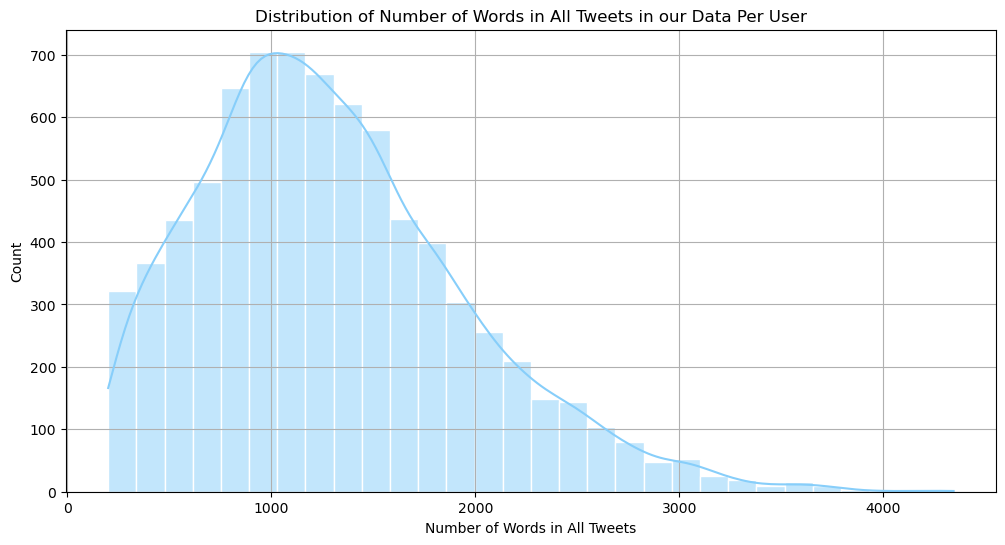

In [4]:
data['number words'] = data['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 6))
plt.grid()
plt.xlabel('Number of Words in All Tweets')
plt.ylabel('Count')
plt.title('Distribution of Number of Words in All Tweets in our Data Per User')

sns.histplot(data=data['number words'], bins=30, kde=True, color='lightskyblue', ec='w')

The distribution of the number of words in all tweets in our dataset is skewed right.

In [5]:
def avg_twt_length(text):
    total_words = 0
    tweet_lst = text.split('|||')
    for tweet in tweet_lst:
        total_words += len(tweet.split(' '))

    return total_words / len(tweet_lst)

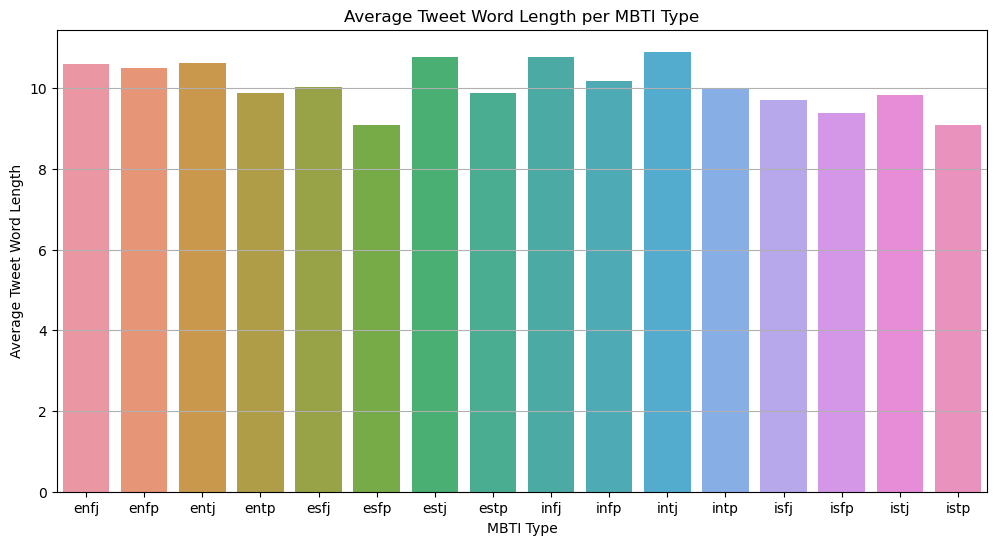

In [6]:
fig, ax = plt.subplots(figsize=(12, 6))

data['avg twt length'] = data['text'].apply(avg_twt_length)
twt_len_by_mbti = data.groupby('label')['avg twt length'].mean()
sns.barplot(x=twt_len_by_mbti.index, y=twt_len_by_mbti)
plt.xlabel('MBTI Type')
plt.ylabel('Average Tweet Word Length')
plt.title('Average Tweet Word Length per MBTI Type')
ax.yaxis.grid()

plt.show()

The average tweet word length per MBTI type is rougly uniform.

In [7]:
char_counts = defaultdict(int)

def count_characters(text):
    words = text.replace('|||', ' ')
    words = words.split(' ')
    
    for word in words:
        for character in word:
            character = character.lower()
            
            if character.isalpha() and character.isascii():
                char_counts[character] += 1
            else:
                char_counts['Other'] += 1

data['text'].apply(count_characters)

0       None
1       None
2       None
3       None
4       None
        ... 
7806    None
7807    None
7808    None
7809    None
7810    None
Name: text, Length: 7811, dtype: object

C:\Users\ritac\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


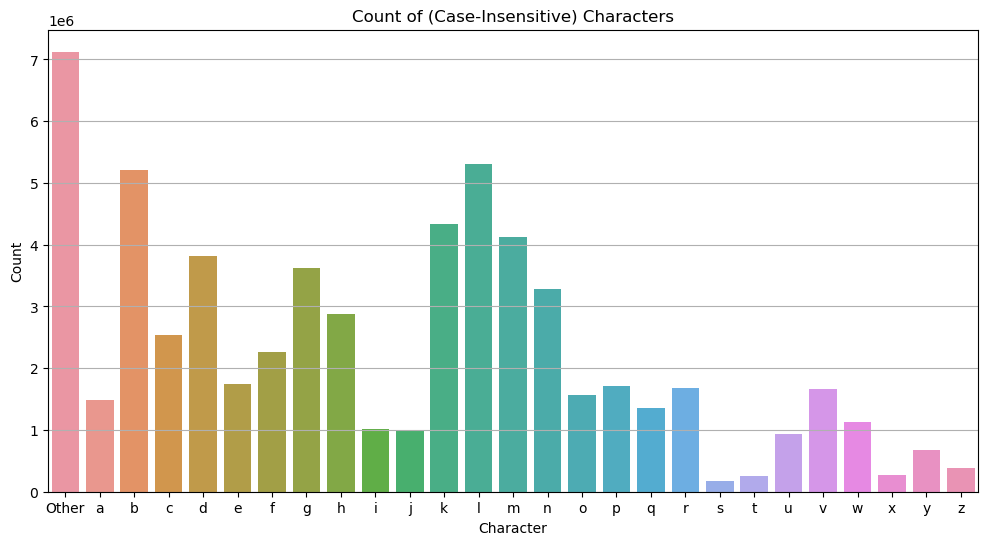

In [8]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.barplot(x=sorted(list(char_counts)), y=list(char_counts.values()))
plt.xlabel('Character')
plt.ylabel('Count')
plt.title('Count of (Case-Insensitive) Characters')
ax.yaxis.grid(True)

plt.show()

The counts of the different characters is not uniform. This is to be expected.

In [9]:
MBTI_types = data['label'].unique()

def find_most_common_words(MBTI_type, n=10):
    all_words = ' '.join(data[data['label'] == MBTI_type]['text'])
    words = [word for word in all_words.split() if word.lower() not in ENGLISH_STOP_WORDS]
    common_words = Counter(words).most_common(n)
    return common_words

In [10]:
all_words = []

for i, MBTI in enumerate(MBTI_types):
    common = find_most_common_words(MBTI)
    words = [tup[0] for tup in common]
    all_words += words

all_words = list(set(all_words))

colors = sns.color_palette("hls", len(all_words))
color_dict = {}

for i in range(len(all_words)):
    color_dict[all_words[i]] = colors[i]

C:\Users\ritac\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\ritac\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\ritac\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\ritac\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\ritac\a

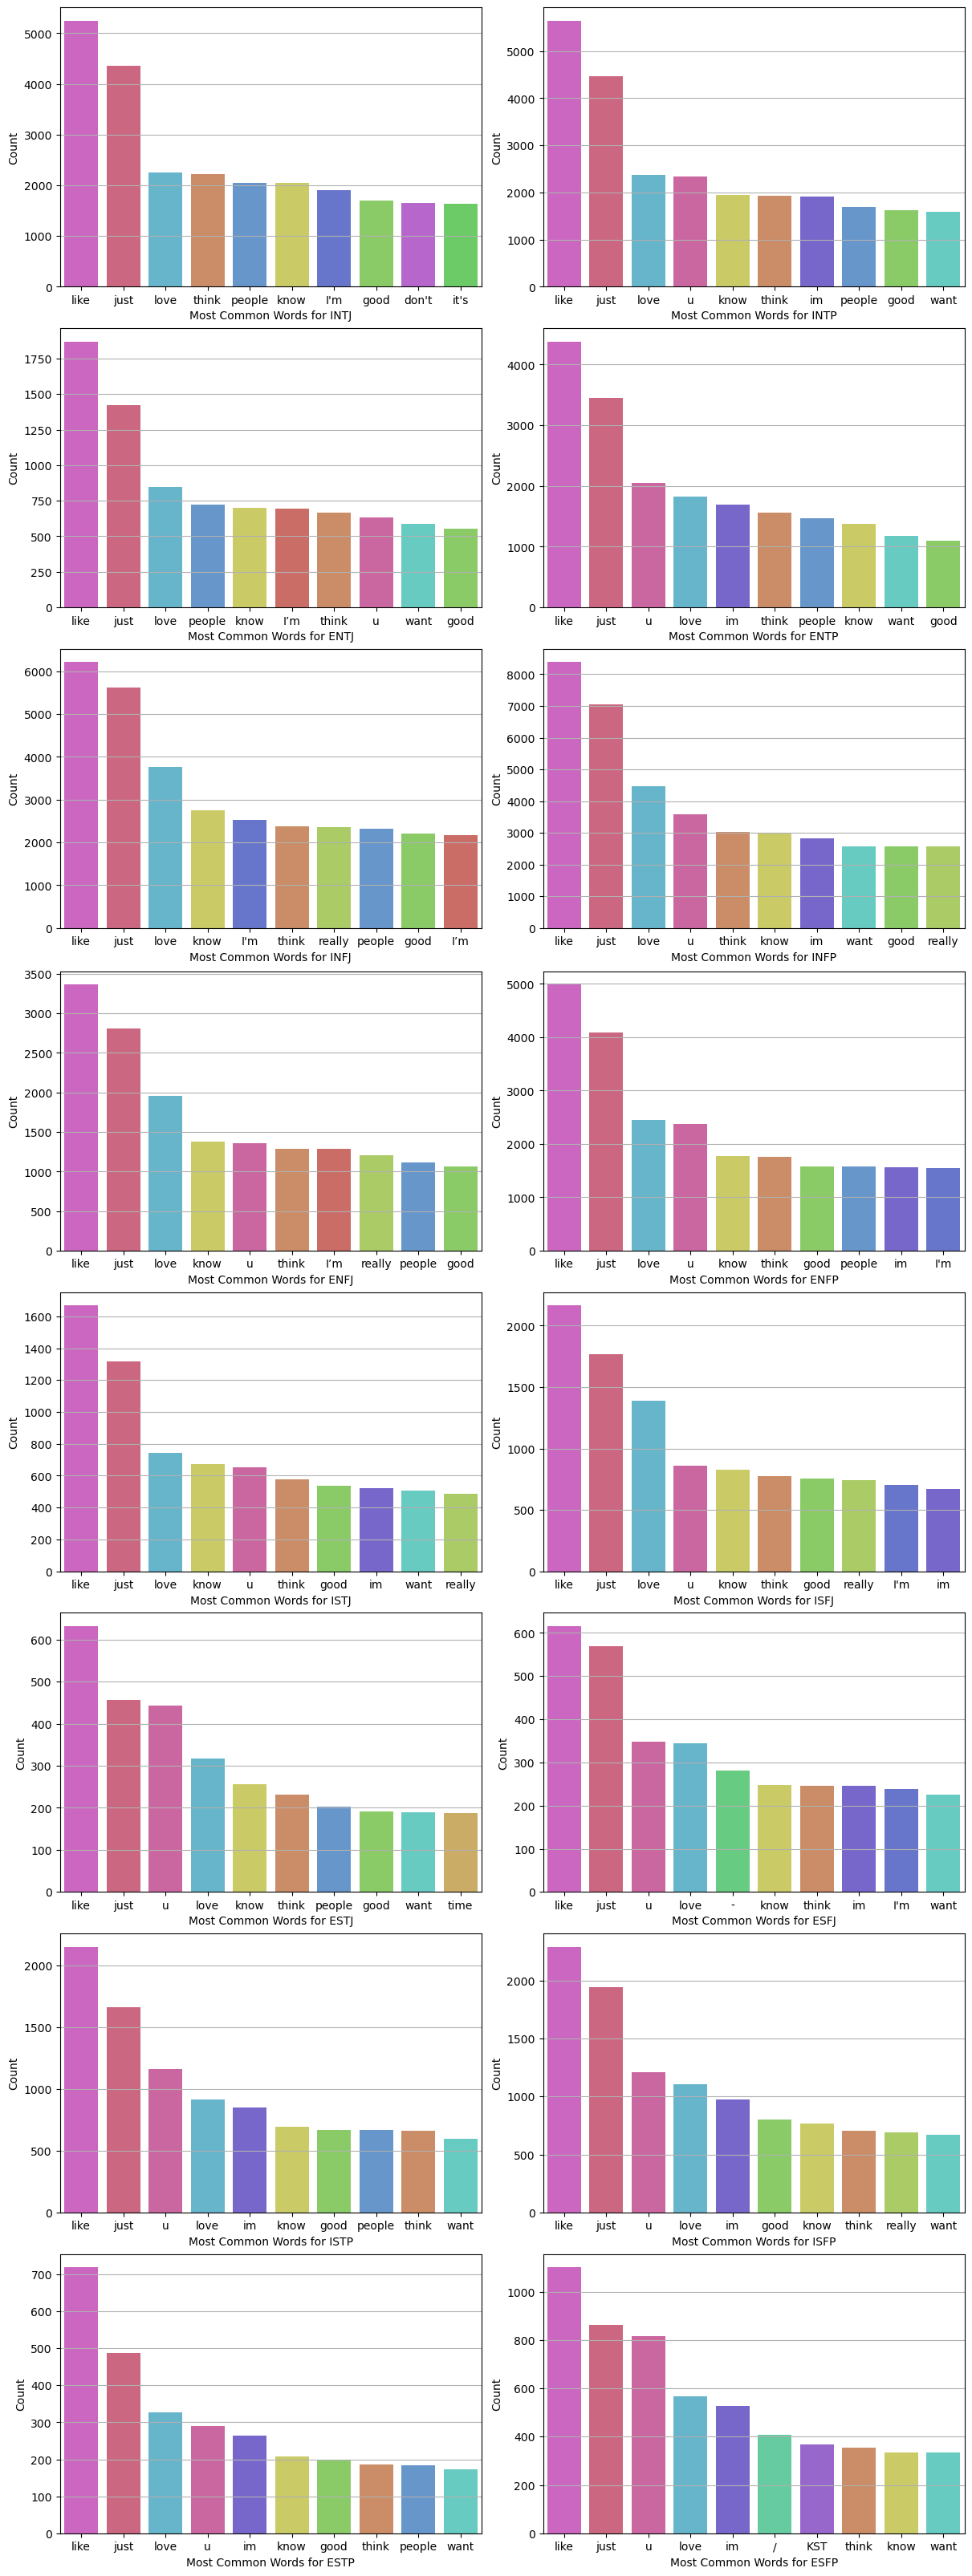

In [11]:
num_cols = 2
num_rows = (len(MBTI_types) + num_cols - 1) // num_cols 
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 4 * num_rows), constrained_layout=True)
axes = axes.flatten()


for i, MBTI in enumerate(MBTI_types):
    common = find_most_common_words(MBTI)
    words = [tup[0] for tup in common]
    colors = [color_dict[word] for word in words]
    counts = [tup[1] for tup in common]
    
    sns.barplot(x=words, y=counts, ax=axes[i], palette=colors)
    axes[i].set_xlabel(f'Most Common Words for {MBTI.upper()}')
    axes[i].set_ylabel('Count')
    axes[i].yaxis.grid()
    
plt.show()

Users, regardless of their MBTI type, have mostly the same most common used words in their tweets.

In [12]:
# note this only partially cleans for EDA purposes, extensive cleaning needed for model
def clean_text(text):
    text = '. '.join(text.split('|||')[:2])
    text_clean = re.sub(r'@\w+', '', text).strip()
    text_clean = re.sub(r'\s+', ' ', text_clean)
    
    return emoji.replace_emoji(text_clean, replace='')
    
data['clean text'] = data['text'].apply(clean_text)
data.head()

,text,label,number words,avg twt length,clean text
0,@Pericles216 @HierBeforeTheAC @Sachinettiyil T...,intj,2351,14.094972,"The Pope is infallible, this is a catholic dog..."
1,@Hispanthicckk Being you makes you look cute||...,intj,943,9.646018,"Being you makes you look cute. On, because the..."
2,@Alshymi Les balles sont réelles et sont tirée...,intj,1646,15.234783,Les balles sont réelles et sont tirées très ra...
3,"I'm like entp but idiotic|||Hey boy, do you wa...",intj,923,5.587065,"I'm like entp but idiotic. Hey boy, do you wan..."
4,@kaeshurr1 Give it to @ZargarShanif ... He has...,intj,1024,6.070352,Give it to ... He has Pica since childhood. Sa...


In [14]:
translator = [Translator()]

def detect_language(text):
    text = text[:1000]
    
    try:
        return translator[0].detect(text).lang
    except Exception as e:
        print(f'Text which errored: {text}')
        translator[0] = Translator()
        return 'unknown'

'en'

In [15]:
data['language'] = data['clean text'].apply(detect_language)

Text which errored: A big hug for channie. 我都係 so far淨係得一樣嘢confirm買到 我已經喺twitter收咗polar同4cut
Text which errored: Rural midwesterners will tell you a story about how their grandparents met thinking it's peak classical romance whe… https://t.co/a9cct2qlQO. Every time you post your work I'm in awe of your application of color theory. Exquisite as always! 
Text which errored: AYO IM FINNA JUMP  https://t.co/8CxzAnH9yx.  https://t.co/OnYtjsLjc2
Text which errored: putangina ang init sa pilipinas . segnen
Text which errored: shittt. manifesting gallesse tapa el gol #PeruvsAustralia
Text which errored: THANKS HAKARI &lt;33. THANK UU MIHANN
Text which errored: I mean both are ENTJ so... . Oalah....  Ga kuat mah  yodahlah 
Text which errored: https://t.co/Xt5dreTboU. wanda kayang
Text which errored: JINNI. JIWOO AND
Text which errored: MEEE LES GO. Yo i'm in EEST
Text which errored:  https://t.co/roGs8ic6Fv.
Text which errored: https://t.co/g0hcVpW5b8. 
Text which errored: me to KEJJDJ. NOOOO
T

In [30]:
data['language'].value_counts()[:15]

language
en         7237
tl          162
id           54
unknown      51
ko           51
es           29
ms           23
ja           18
ar           16
pt           16
zh-CN        15
fr           13
hi           13
it           12
de           12
Name: count, dtype: int64

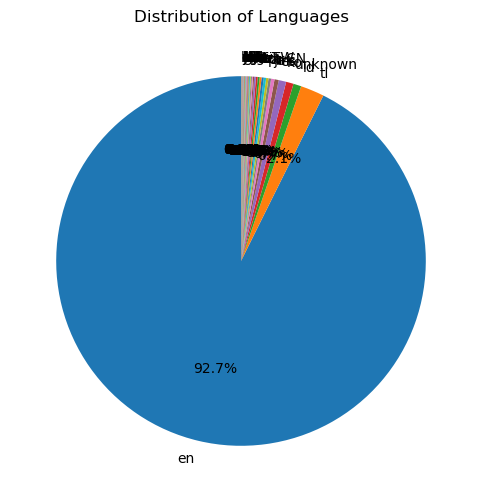

In [28]:
language_counts = data['language'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(language_counts, labels=language_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Languages')
plt.show()

Most of the dataset is in English. We train our model only on English tweets, as translation can make tweets lose their meaning.

In [36]:
en_only = data[data['language'] == 'en'].get(['text', 'label'])
en_only

,text,label
0,@Pericles216 @HierBeforeTheAC @Sachinettiyil T...,intj
1,@Hispanthicckk Being you makes you look cute||...,intj
3,"I'm like entp but idiotic|||Hey boy, do you wa...",intj
4,@kaeshurr1 Give it to @ZargarShanif ... He has...,intj
5,Frances Farmer Will Have Her Revenge On Seattl...,intj
...,...,...
7806,"@sobsjjun God,,pls take care 😕|||@sobsjjun Hir...",intp
7807,@Ignis_02 wow last time i got intp https://t.c...,intp
7808,@akupilled A 100%|||@akupilled That SOMEONE wi...,entp
7809,If you’re #INTJ this one is for you | What is ...,infj


In [41]:
en_only.to_csv('./data/english_only.csv')